<a href="https://colab.research.google.com/github/shiling2007/Python-/blob/main/Copy_of_CVXOTP_mpc_1_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://osqp.org/docs/examples/mpc.html

from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files
# files.download('/content/drive/MyDrive/Colab Notebooks/Lease Payment Formula.ipynb') 
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.8f" % x))
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 999)
pd.set_option("max_colwidth", 500)
# try:
#  device_name = os.environ['COLAB_TPU_ADDR']
#  TPU_ADDRESS = 'grpc://' + device_name
#  print('Found TPU at: {}'.format(TPU_ADDRESS))
# except KeyError:
#  print('TPU not found')
%load_ext autoreload
%autoreload 2

In [2]:
# Generate data for control problem.
import numpy as np
from cvxopt import solvers
solvers.options['show_progress'] = True
import cvxpy as cp

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.8f" % x))

np.random.seed(1)
n = 2
m = 1
T = 8
N = 10*T
N = 300
t_step=0.1
w1, w2, w3=1, 500, 0.001

In [7]:
##test ideas
x = cp.Variable()
y = cp.Variable()
constraints = [0 <= x]
constraints +=[x <=1]
expr = cp.transforms.indicator(constraints)
x.value = .5
print("expr.value = ", expr.value)
x.value = 2
print("expr.value = ", expr.value)

x.value = -2
print("expr.value = ", expr.value)

print( expr)

expr.value =  0
expr.value =  inf
expr.value =  inf
Indicator([Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Variable(()))])


In [11]:
##test ideas
x = cp.Variable()
y = cp.Variable()
constraints = [ x>=0 , x >=1]
# constraints +=[]
expr = cp.transforms.indicator(constraints)
x.value = .5
print("expr.value = ", expr.value)
x.value = 1.001
print("expr.value = ", expr.value)

x.value = -2
print("expr.value = ", expr.value)

print( expr)

expr.value =  inf
expr.value =  0
expr.value =  inf
Indicator([Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, NONNEGATIVE, ()))])


In [46]:
##test ideas
x = cp.Variable()
# y = cp.Parameter()
x.value = 10
y=0.5
# def cust_fun(x,y):
#   if x  >=y:
#     return x-y 

# constraints =[x-y>=0]
# expr = (cp.transforms.indicator(constraints)+1)*(x-y) 
# print("expr.value = ", expr.value)

# z= (expr.value+1.)*(x-y)

x % 5.

# A %= c

# constraints +=[]
# expr = cp.transforms.indicator(constraints)
# x.value = .5
# y.value = 1.
print("expr.value = ", x.value)
# # x.value = 1.001
# print("expr.value = ", expr.value)

# # x.value = -2
# print("expr.value = ", expr.value)

# print( expr)



TypeError: ignored

In [140]:
A=np.array([[1,t_step],[0,1]])
B=np.array([[0],[t_step]])
x_ = np.c_[np.array([20*np.random.rand(1) for i in range(4)]), np.array([4*np.random.rand(1) for i in range(4)])]
x_[::-1].sort(axis=0)
x_0 , x_1 ,x_2 ,x_3 = x_[0,:], x_[1,:], x_[2,:],x_[3,:]
x_0 , x_1 ,x_2 ,x_3

(array([14.40648987, 1.38224291]),
 array([8.34044009, 0.74504085]),
 array([6.04665145, 0.58702356]),
 array([0.00228750, 0.36935438]))

In [141]:
def distance(xj, xi, C=80):
  if xj>xi:
    d=xj-xi
  else:
    d=xj-xi+C
  return d

d_0=distance(x_3[0], x_0[0])
d_1=distance(x_0[0], x_1[0])
d_2=distance(x_1[0], x_2[0])
d_3=distance(x_2[0], x_3[0])

d_0, d_1, d_2, d_3

(65.59579762750374, 6.066049774791681, 2.293788641414685, 6.044363956289898)

In [142]:
# A.shape, B.shape, A, B, x_0 , x_1 ,x_2 ,x_3, d_0, d_1, d_2, d_3

In [143]:
# Constraints

def mpc_setup(n=2, m=1, T=5, d=d_0, x0=x_0):
  umin = np.array([-6]) 
  umax = np.array([4]) 

  # Define problem

  x = cp.Variable((n, T+1))
  u = cp.Variable((m, T))
  x_init = cp.Parameter(n)
  x_init.value = x0

  cost = 0

  constr = [x[:,0] == x_init]
  for t in range(T):
      cost += w1*cp.sum_squares((x[1,t+1]-10)/10) + w3*cp.sum_squares(u[:,t]) + w2*cp.sum( cp.exp( -3*d/20.)) 
      constr += [x[:,t+1] == A@x[:,t] + B@u[:,t]]
      constr += [umin <= u[:,t], u[:,t] <= umax]
  return cp.Problem(cp.Minimize(cost), constr)


In [144]:
data_all_veh=[]
for i in range(150):
  problem0 = mpc_setup(n=2, m=1, T=5, d=d_0, x0=x_0)

  data, chain, inverse_data = problem0.get_problem_data(solver=cp.ECOS)
  soln = chain.solve_via_data(problem0, data)
  problem0.unpack_results(soln, chain, inverse_data)
  # print ("optimal value with ECOS:", problem0.value, '\t', "Solver Runing Time:", soln['info']['timing']['runtime'])
  x_key, u_key=list(problem0.solution.primal_vars.keys())[0], list(problem0.solution.primal_vars.keys())[1]
  x_0=problem0.solution.primal_vars.get(x_key)[:,1]
  u_0=problem0.solution.primal_vars.get(u_key)[:,0]
  # print(x_0)

  problem1 = mpc_setup(n=2, m=1, T=5, d=d_1, x0=x_1)

  data1, chain1, inverse_data1 = problem1.get_problem_data(solver=cp.ECOS)
  soln1 = chain.solve_via_data(problem1, data1)
  problem1.unpack_results(soln1, chain1, inverse_data1)
  # print ("optimal value with ECOS:", problem1.value, '\t', "Solver Runing Time:", soln['info']['timing']['runtime'])
  x_key, u_key=list(problem1.solution.primal_vars.keys())[0], list(problem1.solution.primal_vars.keys())[1]
  x_1=problem1.solution.primal_vars.get(x_key)[:,1]
  u_1=problem1.solution.primal_vars.get(u_key)[:,0]
  # print(x_1)  

  problem2 = mpc_setup(n=2, m=1, T=5, d=d_2, x0=x_2)

  data2, chain2, inverse_data2 = problem2.get_problem_data(solver=cp.ECOS)
  soln2 = chain.solve_via_data(problem2, data2)
  problem2.unpack_results(soln2, chain2, inverse_data2)
  # print ("optimal value with ECOS:", problem2.value, '\t', "Solver Runing Time:", soln['info']['timing']['runtime'])
  x_key, u_key=list(problem2.solution.primal_vars.keys())[0], list(problem2.solution.primal_vars.keys())[1]
  x_2=problem2.solution.primal_vars.get(x_key)[:,1]
  u_2=problem2.solution.primal_vars.get(u_key)[:,0]
  # print(x_2)

  problem3 = mpc_setup(n=2, m=1, T=5, d=d_3, x0=x_3)

  data3, chain3, inverse_data3 = problem3.get_problem_data(solver=cp.ECOS)
  soln3 = chain.solve_via_data(problem3, data3)
  problem3.unpack_results(soln3, chain3, inverse_data3)
  # print ("optimal value with ECOS:", problem3.value, '\t', "Solver Runing Time:", soln['info']['timing']['runtime'])
  x_key, u_key=list(problem3.solution.primal_vars.keys())[0], list(problem3.solution.primal_vars.keys())[1]
  x_3=problem3.solution.primal_vars.get(x_key)[:,1]
  u_3=problem3.solution.primal_vars.get(u_key)[:,0]
  # print(x_3)

  d_0=distance(x_3[0], x_0[0])
  d_1=distance(x_0[0], x_1[0])
  d_2=distance(x_1[0], x_2[0])
  d_3=distance(x_2[0], x_3[0])
  data_all_veh.append(np.c_[x_0.reshape(1,2),u_0,x_1.reshape(1,2),u_1,x_2.reshape(1,2),u_2,x_3.reshape(1,2),u_3].tolist())


In [145]:
np.array(data_all_veh).reshape(150,12)

array([[14.54471416, 1.78224291, 4.00000000, 8.41494418, 1.14504084, 3.99999999, 6.10535381, 0.98702356, 3.99999998, 0.03922293, 0.76935438, 3.99999999],
       [14.72293845, 2.18224291, 4.00000000, 8.52944826, 1.54504084, 3.99999998, 6.20405617, 1.38702356, 4.00000000, 0.11615837, 1.16935438, 3.99999999],
       [14.94116274, 2.58224291, 4.00000000, 8.68395235, 1.94504084, 4.00000000, 6.34275852, 1.78702356, 4.00000000, 0.23309381, 1.56935438, 3.99999998],
       [15.19938703, 2.98224291, 3.99999999, 8.87845643, 2.34504084, 3.99999999, 6.52146088, 2.18702356, 4.00000000, 0.39002925, 1.96935438, 4.00000000],
       [15.49761132, 3.38224291, 4.00000000, 9.11296052, 2.74504084, 4.00000000, 6.74016323, 2.58702356, 4.00000000, 0.58696468, 2.36935437, 3.99999999],
       [15.83583561, 3.78224291, 4.00000000, 9.38746460, 3.14504084, 4.00000000, 6.99886559, 2.98702356, 3.99999999, 0.82390012, 2.76935437, 4.00000000],
       [16.21405990, 4.18224291, 4.00000000, 9.70196868, 3.54504084, 4.00000

In [157]:
df=pd.DataFrame(np.array(data_all_veh).reshape(150,12), 
             columns=['x_0_0', 'x_0_1', 'u_0', 'x_1_0', 'x_1_1', 'u_1', 'x_2_0', 'x_2_1', 'u_2', 'x_3_0', 'x_3_1', 'u_3'])

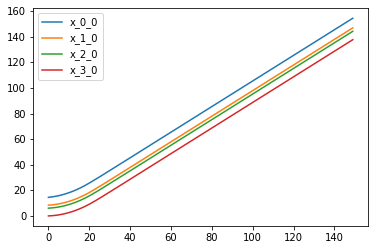

In [158]:
lines = df[['x_0_0','x_1_0','x_2_0','x_3_0']].plot.line()

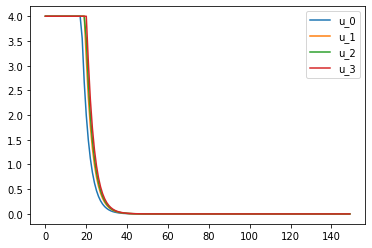

In [159]:
lines = df[['u_0','u_1','u_2','u_3']].plot.line()

In [77]:
# Constraints
umin = np.array([-6]) 
umax = np.array([4]) 

# Define problem

x = cp.Variable((n, T+1))
u = cp.Variable((m, T))
x_init = cp.Parameter(n)

cost = 0

constr = [x[:,0] == x_init]
for t in range(T):
    cost += w1*cp.sum_squares((x[1,t+1]-10)/10) + w3*cp.sum_squares(u[:,t]) 

    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t]]
    constr += [umin <= u[:,t], u[:,t] <= umax]

# sums problem objectives and concatenates constraints.
# constr += [x[1,T] == 10, x[:,0] == x_0]

problem1 = cp.Problem(cp.Minimize(cost), constr)

x_init.value = x_0
data, chain, inverse_data = problem1.get_problem_data(solver=cp.ECOS)
soln = chain.solve_via_data(problem1, data)
problem1.unpack_results(soln, chain, inverse_data)
# print ("optimal value with ECOS:", problem1.value, '\t', "Solver Runing Time:", soln['info']['timing']['runtime'])
x_key, u_key=list(problem1.solution.primal_vars.keys())[0], list(problem1.solution.primal_vars.keys())[1]
x_0=problem1.solution.primal_vars.get(x_key)[:,1]
u_0=problem1.solution.primal_vars.get(u_key)[:,0]

x = cp.Variable((n, T+1))
u = cp.Variable((m, T))
x_init = cp.Parameter(n)

cost = 0

constr = [x[:,0] == x_init]
for t in range(T):
    cost += w1*cp.sum_squares((x[1,t+1]-10)/10) + w3*cp.sum_squares(u[:,t]) 

    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t]]
    constr += [umin <= u[:,t], u[:,t] <= umax]

# sums problem objectives and concatenates constraints.
# constr += [x[1,T] == 10, x[:,0] == x_0]

problem1 = cp.Problem(cp.Minimize(cost), constr)


In [118]:
x_init.value = x_0
data, chain, inverse_data = problem1.get_problem_data(solver=cp.ECOS)
soln = chain.solve_via_data(problem1, data)
problem1.unpack_results(soln, chain, inverse_data)
# print ("optimal value with ECOS:", problem1.value, '\t', "Solver Runing Time:", soln['info']['timing']['runtime'])
x_key, u_key=list(problem1.solution.primal_vars.keys())[0], list(problem1.solution.primal_vars.keys())[1]
x_0=problem1.solution.primal_vars.get(x_key)[:,1]
u_0=problem1.solution.primal_vars.get(u_key)[:,0]
x_0

array([2.64000000, 4.80000000])

In [102]:

x = cp.Variable((n, T+1))
u = cp.Variable((m, T))
x_init = cp.Parameter(n)

cost = 0

constr = [x[:,0] == x_init]
for t in range(T):
    cost += w1*cp.sum_squares((x[1,t+1]-10)/10) + w3*cp.sum_squares(u[:,t]) 

    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t]]
    constr += [umin <= u[:,t], u[:,t] <= umax]

# sums problem objectives and concatenates constraints.
# constr += [x[1,T] == 10, x[:,0] == x_0]

problem2 = cp.Problem(cp.Minimize(cost), constr)



In [116]:
x_init.value =x_0
data, chain, inverse_data = problem2.get_problem_data(solver=cp.ECOS)
soln = chain.solve_via_data(problem2, data)
problem2.unpack_results(soln, chain, inverse_data)
# print ("optimal value with ECOS:", problem2.value, '\t', "Solver Runing Time:", soln['info']['timing']['runtime'])
x_key, u_key=list(problem2.solution.primal_vars.keys())[0], list(problem2.solution.primal_vars.keys())[1]
x_0=problem2.solution.primal_vars.get(x_key)[:,1]
u_0=problem2.solution.primal_vars.get(u_key)[:,0]
x_0, u_0

(array([12.92037285, 9.65384785]), array([1.26178755]))

In [ ]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.8f" % x))
x_star, u_star, solver_runtime=[], [], []
for nsim in range(10):
  x_init.value = x_0
  data, chain, inverse_data = problem.get_problem_data(solver=cp.ECOS)
  soln = chain.solve_via_data(problem, data)
  problem.unpack_results(soln, chain, inverse_data)
  # print ("optimal value with ECOS:", problem.value, '\t', "Solver Runing Time:", soln['info']['timing']['runtime'])
  x_key, u_key=list(problem.solution.primal_vars.keys())[0], list(problem.solution.primal_vars.keys())[1]
  x_0=problem.solution.primal_vars.get(x_key)[:,1]
  u_0=problem.solution.primal_vars.get(u_key)[:,0]
  x_star.append(x_0)
  u_star.append(u_0)
  solver_runtime.append(soln['info']['timing']['runtime'])

  # print('nsim=', nsim, '\t'*2, 'x_0=', x_0, '\t',  'u_0=', u_0)


In [ ]:
x_star, u_star, solver_runtime

([array([-0.00000000, 0.40000000]),
  array([0.04000000, 0.80000000]),
  array([0.12000000, 1.20000000]),
  array([0.24000000, 1.60000000]),
  array([0.40000000, 2.00000000]),
  array([0.60000000, 2.40000000]),
  array([0.84000000, 2.80000000]),
  array([1.12000000, 3.20000000]),
  array([1.44000000, 3.60000000]),
  array([1.80000000, 4.00000000])],
 [array([4.00000000]),
  array([4.00000000]),
  array([4.00000000]),
  array([4.00000000]),
  array([4.00000000]),
  array([4.00000000]),
  array([3.99999999]),
  array([4.00000000]),
  array([4.00000000]),
  array([4.00000000])],
 [0.0005859109999999999,
  0.000566805,
  0.000527176,
  0.000509758,
  0.00056348,
  0.0005827240000000001,
  0.000530508,
  0.00071073,
  0.000556372,
  0.000645679])

In [ ]:
###end here

In [ ]:
X=5; Y=-3
10 // 4

2

In [ ]:
soln

{'eq_dual': array([[0.00000000],
        [0.00533688],
        [0.00000000],
        [0.00533688],
        [0.00000000],
        [0.00387333],
        [0.00000000],
        [0.00279680],
        [0.00000000],
        [0.00199971],
        [0.00000000],
        [0.00140237],
        [0.00000000],
        [0.00094519],
        [0.00000000],
        [0.00058253],
        [0.00000000],
        [0.00027800]]), 'ineq_dual': array([[0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.00000000],
        [0.50002678],
        [-0.49997323],
        [0.00731774],
        [0.00053560],
        [-0.00046440],
        [-0.00026684],
        [0.50001449],
        [-0.49998551],
        [0.00538264],
        [0.00051875],
   

In [ ]:
print ("optimal value with ECOS:", problem.value)

optimal value with ECOS: 6.4174767412140685


In [ ]:
problem.solution.primal_vars

{4002: array([[-0.00000000, -0.00000000, 0.64175074, 1.83166651, 3.48164236, 5.50817762, 7.83153804, 10.37495791, 13.06387533],
        [-0.00000000, 0.64175074, 1.18991576, 1.64997585, 2.02653526, 2.32336042, 2.54341987, 2.68891742, 2.76130610]]),
 4003: array([[0.64175074, 0.54816502, 0.46006009, 0.37655941, 0.29682516, 0.22005945, 0.14549754, 0.07238868]])}

In [ ]:
x_key, u_key=list(problem.solution.primal_vars.keys())[0], list(problem.solution.primal_vars.keys())[1]
problem.solution.primal_vars.get(x_key),problem.solution.primal_vars.get(u_key)

(array([[-0.00000000, -0.00000000, 0.64175074, 1.83166651, 3.48164236, 5.50817762, 7.83153804, 10.37495791, 13.06387533],
        [-0.00000000, 0.64175074, 1.18991576, 1.64997585, 2.02653526, 2.32336042, 2.54341987, 2.68891742, 2.76130610]]),
 array([[0.64175074, 0.54816502, 0.46006009, 0.37655941, 0.29682516, 0.22005945, 0.14549754, 0.07238868]]))

In [ ]:
for t in range(T):
    cost += cp.sum_squares(x[:,t+1]) + cp.sum_squares(u[:,t])  \
        + cp.sum_squares( cp.exp( -0.5*(x[:,t+1] - xf[:,t+1]))) + cp.sum( cp.exp( -0.5*x[:,t+1] - xf[:,t+1]))  + cp.norm1(x[:,t+1]) + cp.tv(x[:,t+1]) \
         + cp.sum_squares(cp.abs(x[:,t+1] - xf[:,t+1] )) # +  cp.sum( exp( -(x[:,t+1]*x[:,t+1])))
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t],
               cp.norm(u[:,t], 'inf') <= 1]
# sums problem objectives and concatenates constraints.
constr += [x[:,T] == 0, x[:,0] == x_0]


problem = cp.Problem(cp.Minimize(cost), constr)
# problem.solve(solver=cp.ECOS, verbose=True)
%time problem.solve(solver=cp.ECOS, verbose=True)

# Disciplined convex programming (DCP) is a system for constructing mathematical expressions with known curvature from a given library of base functions
# ECOS interior point

In [ ]:
from re import VERBOSE
def ball_con():
    # print(f'--- {sys._getframe().f_code.co_name} ---')
    print('ball con')
    np.random.seed(0)

    n = 2

    A = cp.Parameter((n, n))
    z = cp.Parameter(n)
    p = cp.Parameter(n)
    x = cp.Variable(n)
    t = cp.Variable(n)
    obj = cp.Minimize(0.5 * cp.sum_squares(x - p))
    # TODO automate introduction of variables.
    cons = [0.5 * cp.sum_squares(A * t) <= 1, t == (x - z)]
    prob = cp.Problem(obj, cons)

    L = np.random.randn(n, n)
    A.value = L.T
    z.value = np.random.randn(n)
    p.value = np.random.randn(n)

    prob.solve(solver=cp.ECOS)
    print(x.value) 

ball_con()

ball con
[1.03764266 -0.31294773]
